In [ ]:
"""
This script is used to plot metrics for the EC prediction task
"""

import json
import re
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

from Utils.Utils_functions import (
    read_and_preprocess_dataset, 
    create_histogram_and_classes, 
    compute_accuracies_from_confusion_matrices,
    compute_accuracies_at_all_levels, 
    compute_confusion_matrix
)

from Utils.Utils_plot import (
    plot_ec_stratified_pie_chart, 
    plot_accuracy_hist_kshot, 
    plot_confusion_matrix_and_hist, 
    plot_radar_chart
)

from Utils.Utils_metrics import compute_f1_from_confusion_matrix 

In [4]:
DATA_PATH = "./Data_raw/BRENDA_ECREACT.txt"
EC_TEST_DATA_PATH = "Data_json/ec_test_set.json"
DESIRED_DIRECTORY = "LLM_PoC"
BASE_FILENAME1 = "Logs_accuracy/Accuracy_counts"
BASE_FILENAME2 = "Logs_prediction/Pred_target_pairs"
MODEL_NAME = 'Llama3.1-70B'
MODEL_EXTENSION = "_Finetuning_ec_70B_r16_alpha32_lr0.0002_linear_full_5378110" #70b full
N_EXPERIMENTS = 3
SIZE = 8496
PATTERN = re.compile(r'\d+\.\d+\.\d+\.\d+')
TRIMMED = True

File_path: ./Data_raw/BRENDA_ECREACT.txt 
Seed: 0 
Subset_size: 8496 
Split: 0.5

Size of training and test sets: 4248 4248


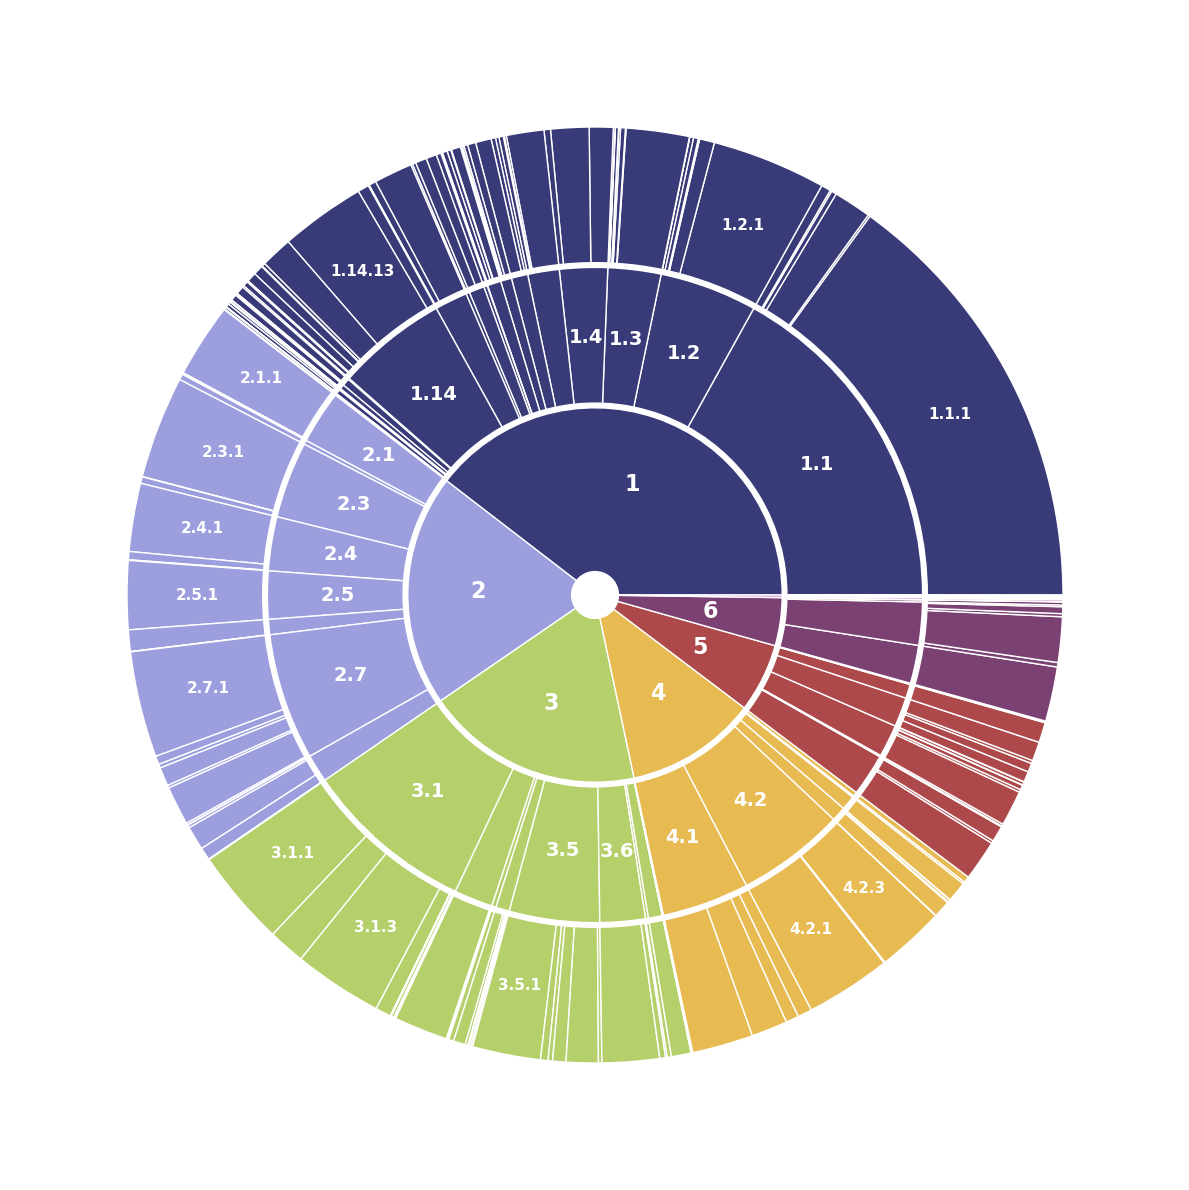


List of accuracies for experiment n.1: ['96.0', '93.2', '93.7', '74.4', '93.3', '100.0']
List of accuracies for experiment n.2: ['96.6', '93.2', '91.7', '70.9', '93.3', '100.0']
List of accuracies for experiment n.3: ['95.7', '92.0', '92.2', '75.6', '97.8', '100.0']
Average accuracy per entry across 3 experiments: ['96.1', '92.8', '92.5', '73.6', '94.8', '100.0']
List of global accuracies [91.78 90.97 92.21]
Average global accuracy over 3 experiments: 91.7 +- 0.5
test data counting distribution dict_values([328, 162, 205, 86, 45, 28])


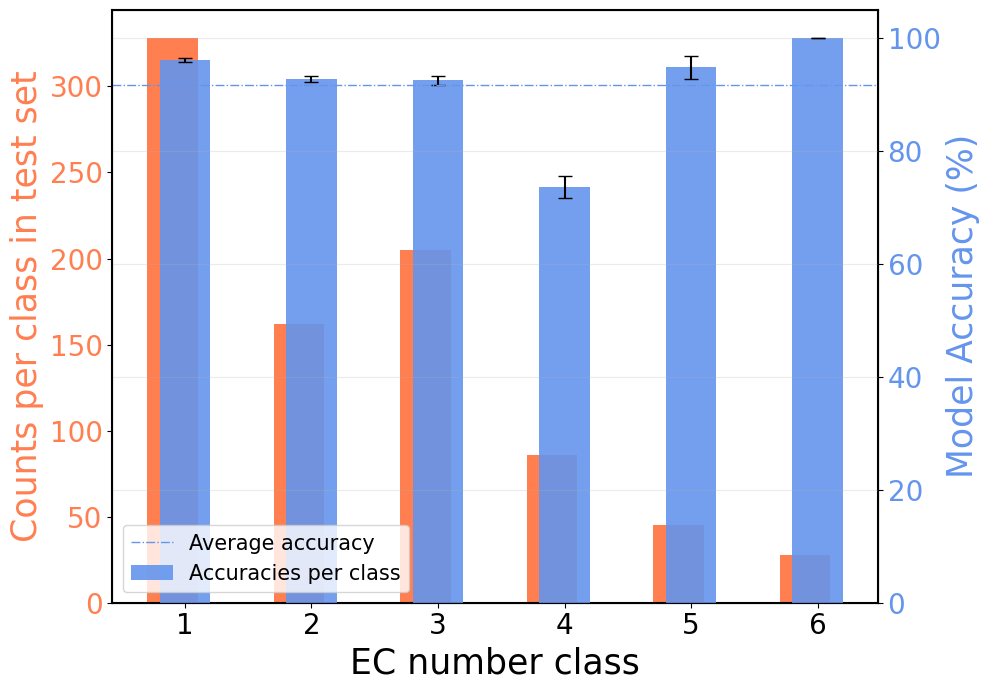

skipping entry n. 129  because target[0] is == 7
skipping entry n. 129  because target[0] is == 7
skipping entry n. 129  because target[0] is == 7

Average accuracies per EC sub-level 1: [0.9177615607982101, 0.9097118349521144, 0.9221021850614726]
Average global accuracy over 3 experiments: 0.917 ± 0.005

Average accuracies per EC sub-level 2: [0.611210182159904, 0.6332063312641883, 0.6076803691365946]
Average global accuracy over 3 experiments: 0.617 ± 0.011

Sub-level 2 accuracies per main EC class:
  Class 1: Mean accuracy = 0.493, Std = 0.036
  Class 2: Mean accuracy = 0.627, Std = 0.012
  Class 3: Mean accuracy = 0.712, Std = 0.013
  Class 4: Mean accuracy = 0.625, Std = 0.038
  Class 5: Mean accuracy = 0.717, Std = 0.019
  Class 6: Mean accuracy = 0.963, Std = 0.000
Recovered global average accuracy for sub-level 2 from class means: 0.690

Average accuracies per EC sub-level 3: [0.4865271423652227, 0.5029280154832052, 0.48775851154192457]
Average global accuracy over 3 experiment

/Users/ldifruscia/Desktop/vscode/Projects/LLM_PoC/Utils_functions.py:852: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(


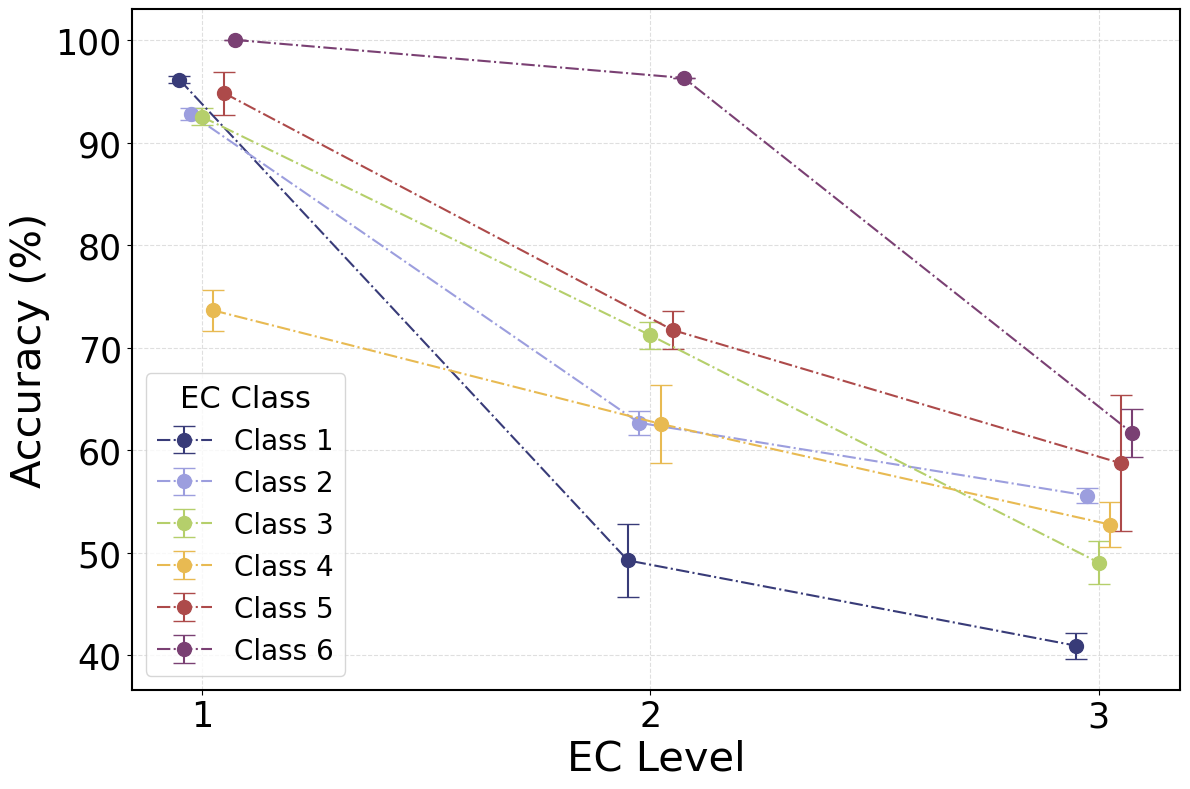

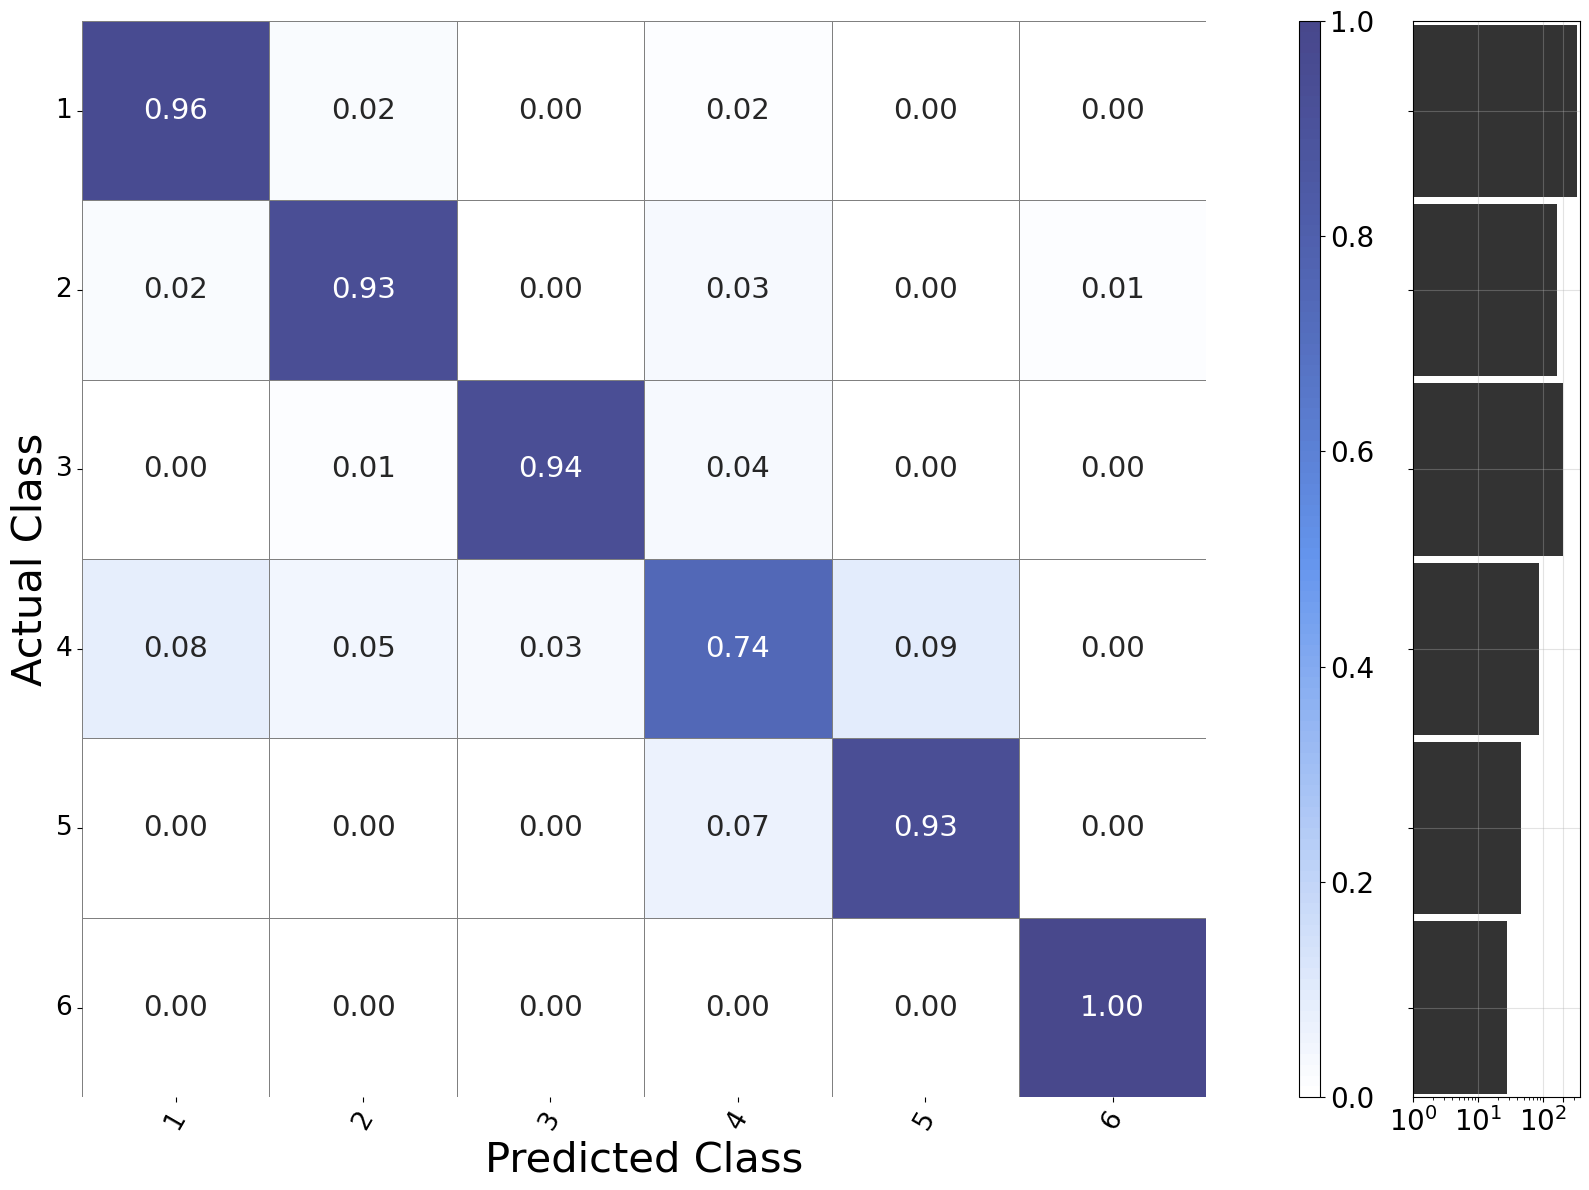

Macro F1 score: 0.9164973396319137
F1 scores per class: [0.9272936433674008, 0.9253501851001045, 0.9486724646840415, 0.7850125045071167, 0.9211935730680949, 0.991461667064724], 0.9164973396319137
Precision: [0.8964234245908494, 0.9186986244523064, 0.961075622426262, 0.8305785002857577, 0.9093655589123867, 0.983067905985436], 0.9165349394421664
Recall: [0.9603658536585367, 0.9320987654320989, 0.9365853658536586, 0.7441860465116282, 0.9333333333333332, 1.0], 0.9177615607982093


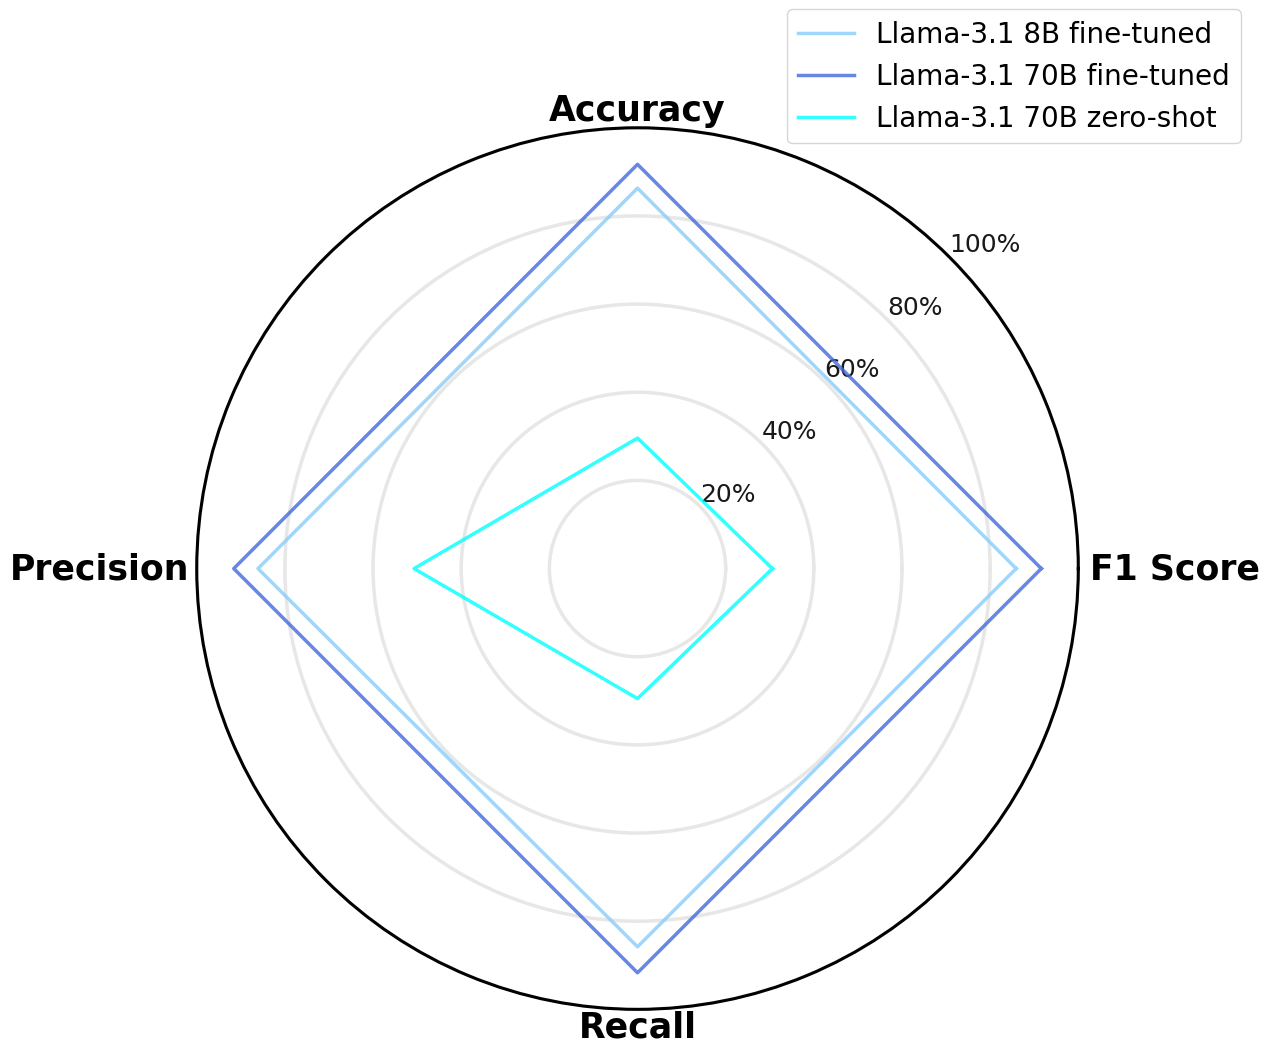

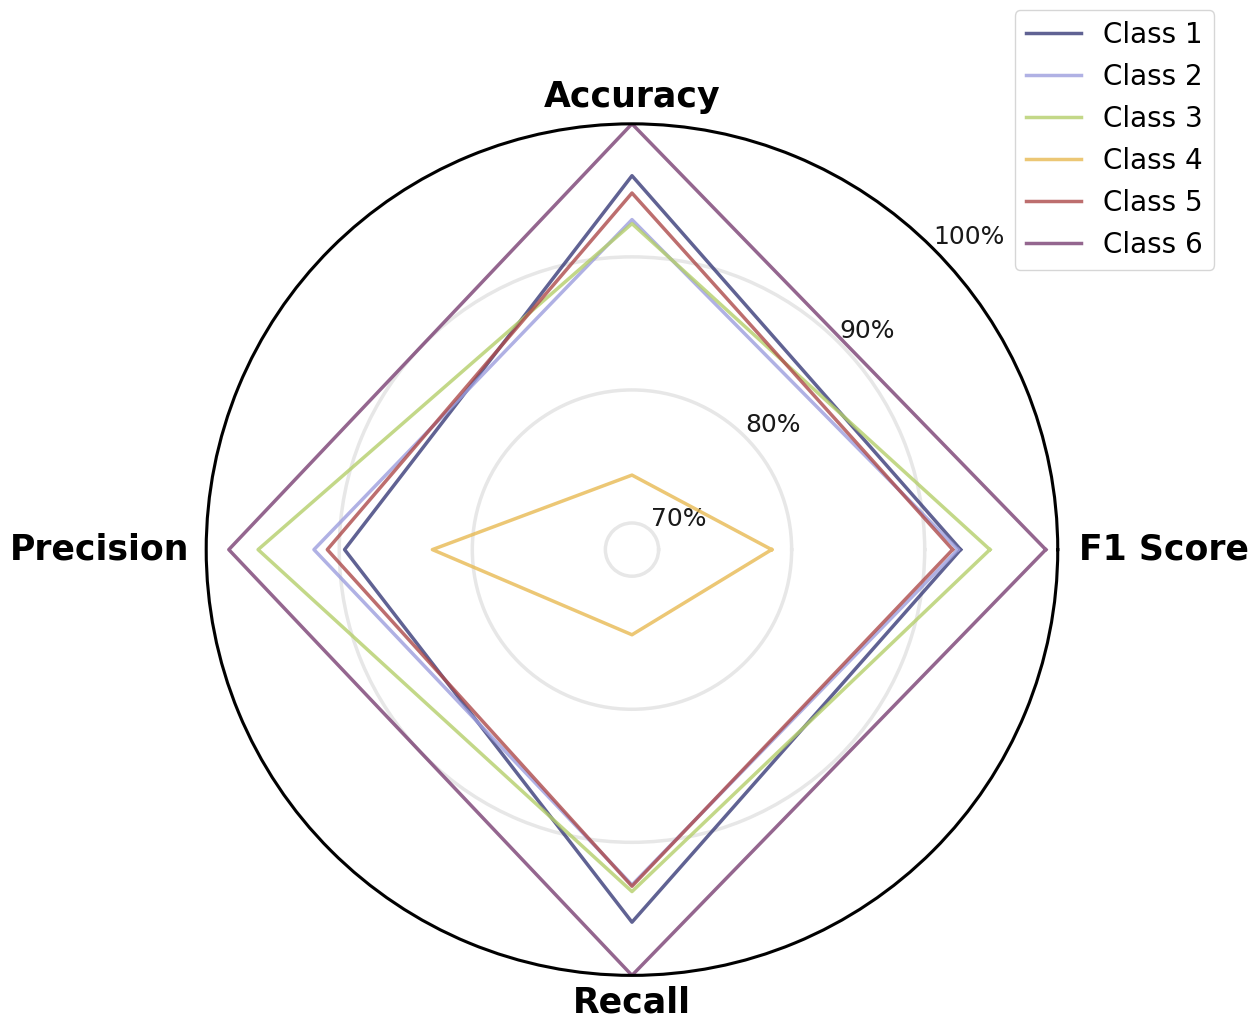

In [5]:
if __name__ == "__main__":

    # DATA PREPROCESSING
    
    (
        data,
        subset_data,
        train_data,
        test_data,
        train_set,
        train_targets,
        test_set,
        test_targets,
        train_size,
        test_size,
        origin,
    ) = read_and_preprocess_dataset(file_path = DATA_PATH, subset_size=SIZE)

    targets = train_targets+test_targets

    ec_numbers = sorted((targets),key=lambda x: [int(part) for part in x.split('.')])
    plot_ec_stratified_pie_chart(ec_numbers, min_angle_to_plot=8, depth=3, label_radii=[0.25, 0.55, 0.85], label_font_sizes=[16, 14, 11])

    with open(EC_TEST_DATA_PATH, "r") as f: data = json.load(f)
    ec_test_targets = tuple(item["raw_output"] for item in data if "raw_output" in item and item["raw_output"])
    
    test_hist, test_hist_classes = create_histogram_and_classes(ec_test_targets)

    filename1 = BASE_FILENAME1 + MODEL_EXTENSION
    filename2 = BASE_FILENAME2 + MODEL_EXTENSION
        
    with open(filename1, 'r') as f:
        N_experiments_class_accuracy_counts = json.load(f)

    with open(filename2, 'r') as f:
        N_experiments_all_pred_target_pairs = json.load(f)

    # EC LEVEL HISTOGRAM

    if TRIMMED:
        filtered_test_hist_classes = {key: value for key, value in test_hist_classes.items() if key != 7}
        # Remove the key '7' from each dictionary in the list
        filtered_N_experiments_class_accuracy_counts = [{key: value for key, value in item.items() if key != '7'} for item in N_experiments_class_accuracy_counts]
        Llama3_mean_accuracies, Llama3_std_accuracies, Llama3_total_mean_accuracy, Llama3_total_std_accuracy = plot_accuracy_hist_kshot(N_EXPERIMENTS, filtered_N_experiments_class_accuracy_counts, filtered_test_hist_classes, test_size, MODEL_NAME, y_lim = 100, trimmed = TRIMMED)
    else:
        Llama3_mean_accuracies, Llama3_std_accuracies, Llama3_total_mean_accuracy, Llama3_total_std_accuracy = plot_accuracy_hist_kshot(N_EXPERIMENTS, N_experiments_class_accuracy_counts, test_hist_classes, test_size, MODEL_NAME, y_lim = 100)

    # STRATIFIED ACCURACY PER LEVEL

    N_experiments_all_pred_target_pairs
    pattern = PATTERN
    # Maintain the list of lists structure and extract EC numbers safely
    ec_numbers_nested = [[re.findall(pattern, item)[0] if re.findall(pattern, item) else '0' for item in sublist] for sublist in N_experiments_all_pred_target_pairs]


    accuracies_Llama3 = compute_accuracies_at_all_levels(
        ec_test_targets, 
        ec_numbers_nested,
        trimmed = TRIMMED,
    )
    (Llama_mean, 
    Llama_std, 
    level2_mean, 
    level2_std, 
    level3_mean, 
    level3_std) = compute_accuracies_from_confusion_matrices(
        accuracies_Llama3,                                                                        
        N_EXPERIMENTS, 
        stratified=True, 
        plot_stratified_per_experiment=True)


    # CONFUSION MATRIX

    colors = ['white', 'cornflowerblue', (0.10, 0.10, 0.44, 0.8)]
    n_bins = 100
    cmap_name = 'cornflowerblue_custom'

    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    level = 1
    accuracy_levels = compute_accuracies_at_all_levels(ec_test_targets, N_experiments_all_pred_target_pairs, tags=True)
    values = 'dict_test_'+ str(level)
    (confusion_matrix, 
     reduced_confusion_matrix, 
     all_classes, 
     actual_classes) = compute_confusion_matrix(accuracies_Llama3, exp = 0, level = level)
    plot_confusion_matrix_and_hist(reduced_confusion_matrix, all_classes, actual_classes, level, hist = accuracy_levels[values], cmap = cm)

    # ADDITIONAL METRICS

    f1_macro, f1_scores, precision, recall = compute_f1_from_confusion_matrix(reduced_confusion_matrix)

    print(f"Macro F1 score: {f1_macro}")
    print(f"F1 scores per class: {f1_scores}, {np.mean(f1_scores)}")
    print(f"Precision: {precision}, {np.mean(precision)}")
    print(f"Recall: {recall}, {np.mean(recall)}")


    # RADAR CHART N.1

    categories = ["F1 Score", "Accuracy", "Precision", "Recall"]

    values_list = [
        [0.859, 0.863, 0.861, 0.858],  # 8B full
        [0.916, 0.917, 0.916, 0.917],  # 70B full
        [0.306, 0.296, 0.507, 0.295]   # zero-shot
    ]
    label_radius1 = 1.22 
    label_radius2 = 1.04 
    colors = ["lightskyblue", "royalblue", "cyan"]
    y_ticks = [0.2, 0.4, 0.6, 0.8, 1.0]
    y_labels = ["20%", "40%", "60%", "80%", "100%"]
    legend_labels = ["Llama-3.1 8B fine-tuned", "Llama-3.1 70B fine-tuned", "Llama-3.1 70B zero-shot"]

    plot_radar_chart(values_list, categories=categories, colors=colors, 
                    label_radius1 = label_radius1, label_radius2 = label_radius2,
                    y_ticks=y_ticks, y_labels=y_labels, y_min=0, y_max=1.0,legend_labels=legend_labels)
    
    # RADAR CHART N.2

    values = [
        [0.927, 0.925, 0.949, 0.785, 0.921, 0.991],
        [0.961, 0.928, 0.925, 0.736, 0.948, 1.0],
        [0.896, 0.919, 0.961, 0.830, 0.909, 0.983],
        [0.960, 0.932, 0.937, 0.744, 0.933, 1.00],
    ]

    label_radius1 = 1.08
    label_radius2 = 1.02 
    values_list = np.array(values).T.tolist()

    colors = [
        [0.22, 0.23, 0.47, 1.0],
        [0.61, 0.62, 0.87, 1.0],
        [0.71, 0.81, 0.42, 1.0],
        [0.91, 0.73, 0.32, 1.0],
        [0.68, 0.29, 0.29, 1.0],
        [0.48, 0.25, 0.45, 1.0]
    ]

    legend_labels = ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
    y_ticks = [0.7, 0.8, 0.9, 1.0]
    y_labels = ["70%", "80%", "90%", "100%"]

    plot_radar_chart(values_list=values_list, categories=categories, colors=colors, 
                    label_radius1 = label_radius1, label_radius2 = label_radius2,
                    y_ticks=y_ticks, y_labels=y_labels, y_min=0.68, y_max=1.0, legend_labels=legend_labels)
